# Demand Forecasting Using DeepAR 

In this notebook, we develop a prototype of the demand forecasting solution using DeepAR. 

We use the DeepAR implementation provided by GluonTS library [1]. GluonTS provides a number of forecasting models under a unified interface.

### References
[1] https://github.com/awslabs/gluonts

In [3]:
import pathlib
import numpy as np
print(np.__version__)
import pandas as pd
from tabulate import tabulate
import datetime

from gluonts.dataset.split import split

from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import platform
print(f'Python {platform.python_version()}')

1.23.5
Python 3.9.13


In [4]:
#
# Helper functions
#

# Print a dataset 
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
# Highlight weekends on a time series chart
def highlight_weekends(ax, color='k', alpha=0.1):
    ax.set_ylim(*ax.get_ylim())
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)
    weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor=color, alpha=alpha)
    ax.set_xlim(xmin, xmax)

# Data Loading

We use a small dataset that mimics daily sales series for a retail chain. The dataset consists of 500 sales time series for 10 stores and 50 items (SKUs). Each series spans 5 years.

In [6]:
data_path = '/Users/jeevikasuresh/Downloads/DemandForecasting'
df = pd.read_csv(f'{data_path}/store-item-sales.csv.zip', compression='zip', parse_dates=['date'], index_col='date')
df.sort_values(['date'], axis=0, ascending=[True], inplace=True)

print_df(df)
print(f'Unique stores: {df.store.nunique()}, unique items: {df.item.nunique()}')

#
# Set the train/test split date
#
prediction_length = 60
dates = df.index.unique().sort_values()
split_date = dates[-prediction_length]
print(f'Unique dates: {len(dates)} (from {dates[0]} to {dates[-1]}), split on {split_date}')

+---------------------+---------+--------+---------+
| date                |   store |   item |   sales |
|---------------------+---------+--------+---------|
| 2013-01-01 00:00:00 |       1 |      1 |      13 |
| 2013-01-01 00:00:00 |       7 |     12 |      26 |
| 2013-01-01 00:00:00 |       7 |     46 |      27 |
| 2013-01-01 00:00:00 |       8 |     12 |      54 |
| 2013-01-01 00:00:00 |       9 |     12 |      35 |
| 2013-01-01 00:00:00 |      10 |     12 |      41 |
| 2013-01-01 00:00:00 |       6 |     46 |      23 |
| 2013-01-01 00:00:00 |       1 |     13 |      37 |
| 2013-01-01 00:00:00 |       2 |     13 |      51 |
| 2013-01-01 00:00:00 |       5 |     46 |      20 |
+---------------------+---------+--------+---------+
913000 rows x 3 columns
Unique stores: 10, unique items: 50
Unique dates: 1826 (from 2013-01-01 00:00:00 to 2017-12-31 00:00:00), split on 2017-11-02 00:00:00


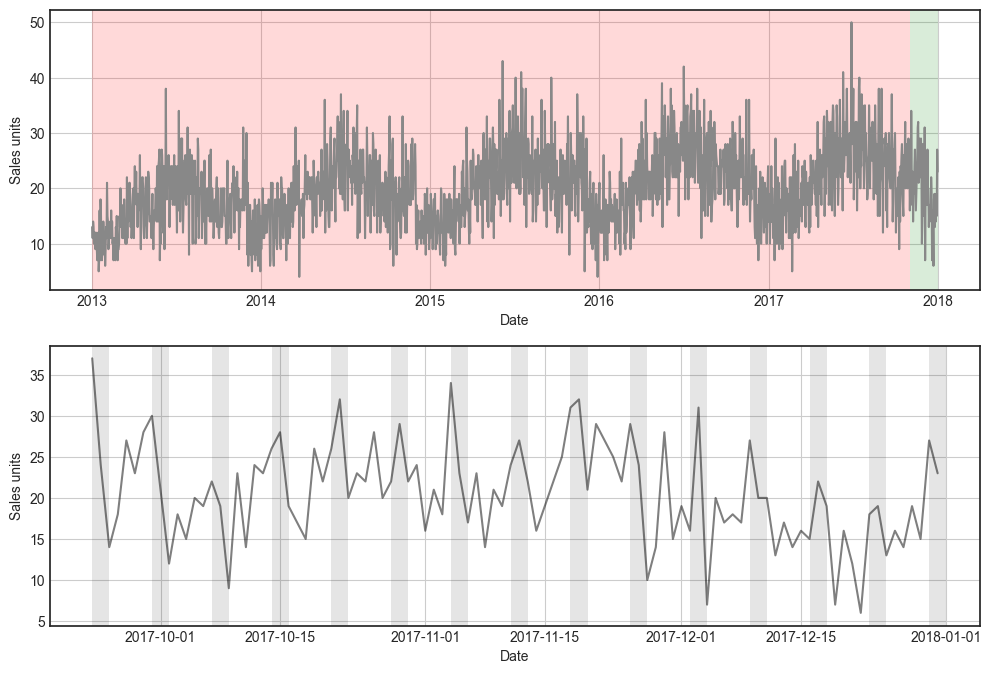

In [7]:
#
# Visualize an example sales series
#
df_one_item = df.query('item == 1 & store == 1').sort_values(["date"], axis=0, ascending=[True])

#
# Full date range
#
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Sales units')
ax[0].grid(True)
ax[0].axvspan(dates[0], dates[-prediction_length], facecolor='r', alpha=0.15)
ax[0].axvspan(dates[-prediction_length], dates[-1], facecolor='g', alpha=0.15)
ax[0].plot(df_one_item.index, df_one_item['sales'], c='#888888')

#
# Last 100 days
#
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Sales units')
ax[1].plot(df_one_item[-100:].index, df_one_item[-100:]['sales'], c='k', alpha=0.5)
highlight_weekends(ax[1])
ax[1].grid(True)

# DeepAR Training and Evaluation

In [9]:
df['series_id'] = df['store'].astype(str) + '_' + df['item'].astype(str)

ds = PandasDataset.from_long_dataframe(df, 
                                       target='sales', 
                                       item_id='series_id')

ds_train, test_template = split(
    ds, date=pd.Period(split_date, freq="1D")
)

ds_test = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=1,
)

estimator = DeepAREstimator(
    freq='1D', 
    prediction_length=prediction_length, 
    trainer=Trainer(epochs=5)
)
predictor = estimator.train(ds_train)

100%|██████████| 50/50 [00:04<00:00, 10.88it/s, epoch=5/5, avg_epoch_loss=3.44]


In [10]:
forecast_it, ts_it = make_evaluation_predictions(dataset=ds_test.dataset, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=[0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(ds_test))

metric_names = ['item_id', 'MSE', 'MAPE', 'Coverage[0.9]', 'Coverage[0.95]', 'Coverage[0.99]']

print_df(item_metrics[metric_names])

for m in metric_names[1:]:
    print(f'{m} = {agg_metrics[m]}')

Running evaluation: 100%|██████████| 500/500 [00:00<00:00, 3474.15it/s]


+----+-----------+----------+----------+-----------------+------------------+------------------+
|    |   item_id |      MSE |     MAPE |   Coverage[0.9] |   Coverage[0.95] |   Coverage[0.99] |
|----+-----------+----------+----------+-----------------+------------------+------------------|
|  0 |      10_1 |  27.4252 | 0.21305  |        0.983333 |         0.983333 |         1        |
|  1 |     10_10 | 160.669  | 0.139856 |        0.933333 |         0.983333 |         0.983333 |
|  2 |     10_11 | 129.275  | 0.111168 |        0.833333 |         0.9      |         0.983333 |
|  3 |     10_12 | 161.136  | 0.124812 |        0.883333 |         0.9      |         0.966667 |
|  4 |     10_13 | 164.726  | 0.113658 |        0.883333 |         0.933333 |         1        |
|  5 |     10_14 |  96.3041 | 0.124603 |        0.916667 |         0.983333 |         1        |
|  6 |     10_15 | 175.594  | 0.111512 |        0.916667 |         0.966667 |         0.966667 |
|  7 |     10_16 |  36.7174 | 

# Forecast Visualization

(10.0, 70.0)

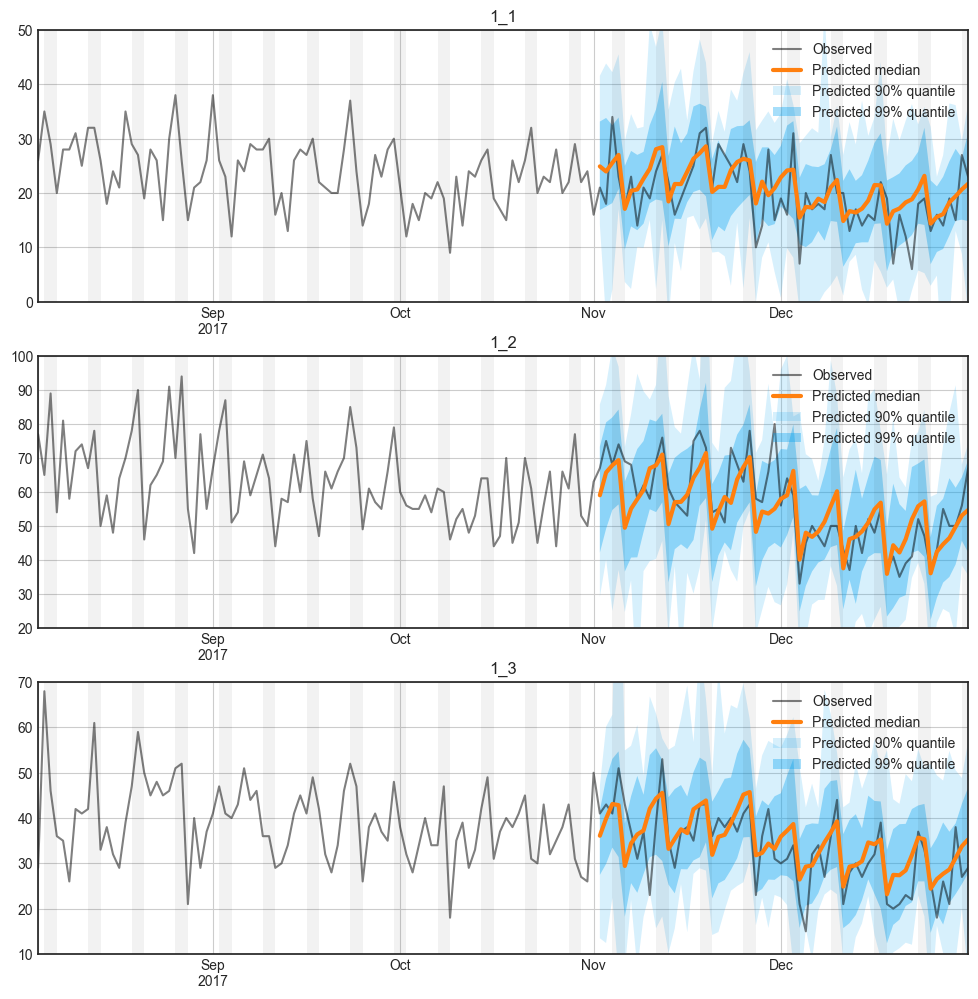

In [11]:
def plot_forecast(ax, forecast, prediction_intervals, linewidth, linecolor, rangecolor):
    ps = [50.0] + [
        50.0 + f * c / 2.0
        for c in prediction_intervals
        for f in [-1.0, +1.0]
    ]
    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.35

    ps_data = [forecast.quantile(p / 100.0) for p in percentiles_sorted]
    i_p50 = len(percentiles_sorted) // 2
    
    p50_data = ps_data[i_p50]
    ax.plot(
        forecast.index.to_timestamp(), 
        p50_data, 
        color=linecolor, 
        linewidth=linewidth
    )

    for i in range(len(percentiles_sorted) // 2):
        ptile = percentiles_sorted[i]
        alpha = alpha_for_percentile(ptile)
        ax.fill_between(
                forecast.index.to_timestamp(),
                ps_data[i],
                ps_data[-i - 1],
                facecolor=rangecolor,
                alpha=alpha,
                interpolate=True
        )
    

indices = []
for i, f in enumerate(forecasts):
    if f.item_id in ('1_1', '1_2', '1_3'):
        indices.append(i)
n_plot = len(indices)

fig, axes = plt.subplots(n_plot, 1, figsize=(12, n_plot * 4))

for i, ax in zip(indices, axes):
    tests[i][-5 * prediction_length // 2 :].plot(ax=ax, color='k', alpha=0.5)
    
    mean_data = np.mean(forecasts[i]._sorted_samples, axis=0)
    plot_forecast(ax, forecasts[i], prediction_intervals=[90.0, 99.0], linewidth=3, linecolor='C1', rangecolor='#00a1f1')
    
    ax.legend(['Observed', 'Predicted median', 'Predicted 90% quantile', 'Predicted 99% quantile'])
    highlight_weekends(ax, alpha=0.05)
    ax.set_title(forecasts[i].item_id)
    ax.grid(True)
    
axes[0].set_ylim([0, 50])
axes[1].set_ylim([20, 100])
axes[2].set_ylim([10, 70])